## QC and integrate Visium objects

In [1]:
import sys 
import os
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d")
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import hdf5plugin

# Import key analysis packages
import scvi


# Define repo path and add it to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
# Define paths for plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
results_path = os.path.join(repo_path, 'results')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [3]:
# Set pandas display options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [4]:
%load_ext autoreload
%autoreload 2
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
#from plotting.utils import plot_grouped_boxplot, calc_figsize

In [5]:
# Set plot formatting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from matplotlib import rcParams
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

In [102]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', dpi_save=300)
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [132]:
def select_slide(adata, s, s_col='SampleID'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Load combined Visium object

In [8]:
meta_df = pd.read_excel(f'{data_path}/ThyAge_spatial_metadata_v2_2025-09-02.xlsx')
adata_vis = ad.read_h5ad(f'{data_path}/visium/thyAgeing_Visium_OCT_FFPE_raw_2025-09-02.zarr')

In [10]:
def detect_outliers_tech(adata_vis, tech, age, quant = 0.05): 
    # Calculate the percentiles
    fifth_quant = adata_vis[(adata_vis.obs['chemistry_simple'] == tech) & (adata_vis.obs['age_group'] == age)].obs['total_counts'].quantile(quant)
    print(f'Removing fifth quantile for {tech}:{age}, values lower than {fifth_quant}')
    # Subset the dataset
    adata_vis.obs.loc[((adata_vis.obs['chemistry_simple'] == tech) & (adata_vis.obs['age_group'] == age)) & (adata_vis.obs['total_counts'] < fifth_quant), '5quant_outlier'] = 'outlier'

In [11]:
for chem in ['Visium_OCT', 'Visium_FFPE']:
    for age_g in ['adult', 'paed_early', 'paed_late']:
        detect_outliers_tech(adata_vis, tech = chem, age = age_g, quant = 0.05)

Removing fifth quantile for Visium_OCT:adult, values lower than 16.0
Removing fifth quantile for Visium_OCT:paed_early, values lower than 215.0
Removing fifth quantile for Visium_OCT:paed_late, values lower than 1043.2
Removing fifth quantile for Visium_FFPE:adult, values lower than nan
Removing fifth quantile for Visium_FFPE:paed_early, values lower than 1202.0000000000002
Removing fifth quantile for Visium_FFPE:paed_late, values lower than 1166.0


In [15]:
adata_vis.obs['donor']

THY81-AACAATGGAACCACAT-1                NIHTHY0081
THY81-AACACCATTCGCATAC-1                NIHTHY0081
THY81-AACACCGAGCTTGGAT-1                NIHTHY0081
THY81-AACACGACAACGGAGT-1                NIHTHY0081
THY81-AACACGCAGATAACAA-1                NIHTHY0081
                                           ...    
WSSS_THYst9383372-TTGTGGTGGTACTAAG-1           A43
WSSS_THYst9383372-TTGTTAGCAAATTCGA-1           A43
WSSS_THYst9383372-TTGTTCAGTGTGCTAC-1           A43
WSSS_THYst9383372-TTGTTGGCAATGACTG-1           A43
WSSS_THYst9383372-TTGTTGTGTGTCAAGA-1           A43
Name: donor, Length: 112163, dtype: category
Categories (18, object): ['A43', 'A45', 'A53', 'A56', ..., 'Z4', 'Z6', 'Z15', 'Z17']

In [16]:
adata_vis_filt = adata_vis[(adata_vis.obs['n_genes_by_counts']>200) & (adata_vis.obs['5quant_outlier']!='outlier')&
                           (~adata_vis.obs['donor'].isin(['A53', 'A56'])),:].copy()

In [17]:
adata_vis_filt.layers['counts'] = adata_vis_filt.X.copy()

In [18]:
from scvi_wrapper2 import run_scvi

In [19]:
markers = pd.read_csv(f'{data_path}/markers/thyAgeing_all_marker_genes_v1_2025-09-01.csv', 
                      index_col = 0)

In [20]:
mrkrs = [i for i in markers['marker_gene'].tolist() if i in adata_vis_filt.var_names.tolist()]

Removed excluded genes
Highly variable genes selected in total (96796, 5000)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_datalo

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


scVI model trained
UMAP performed


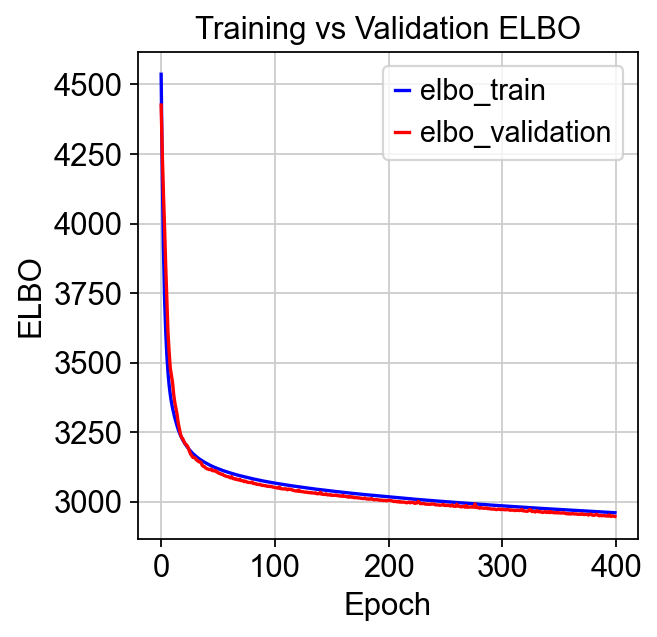

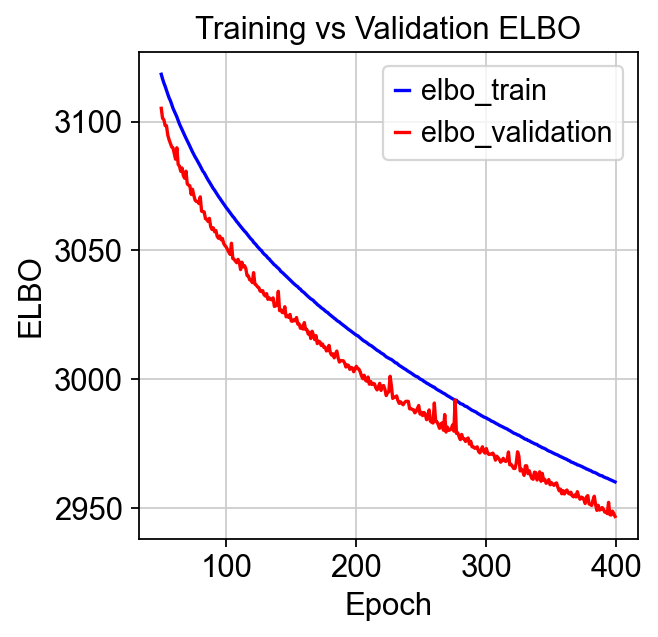

Plotting cat_covs
Plotting cont_covs


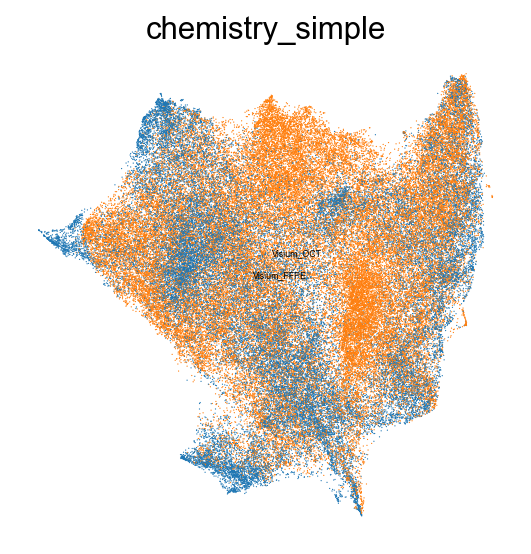

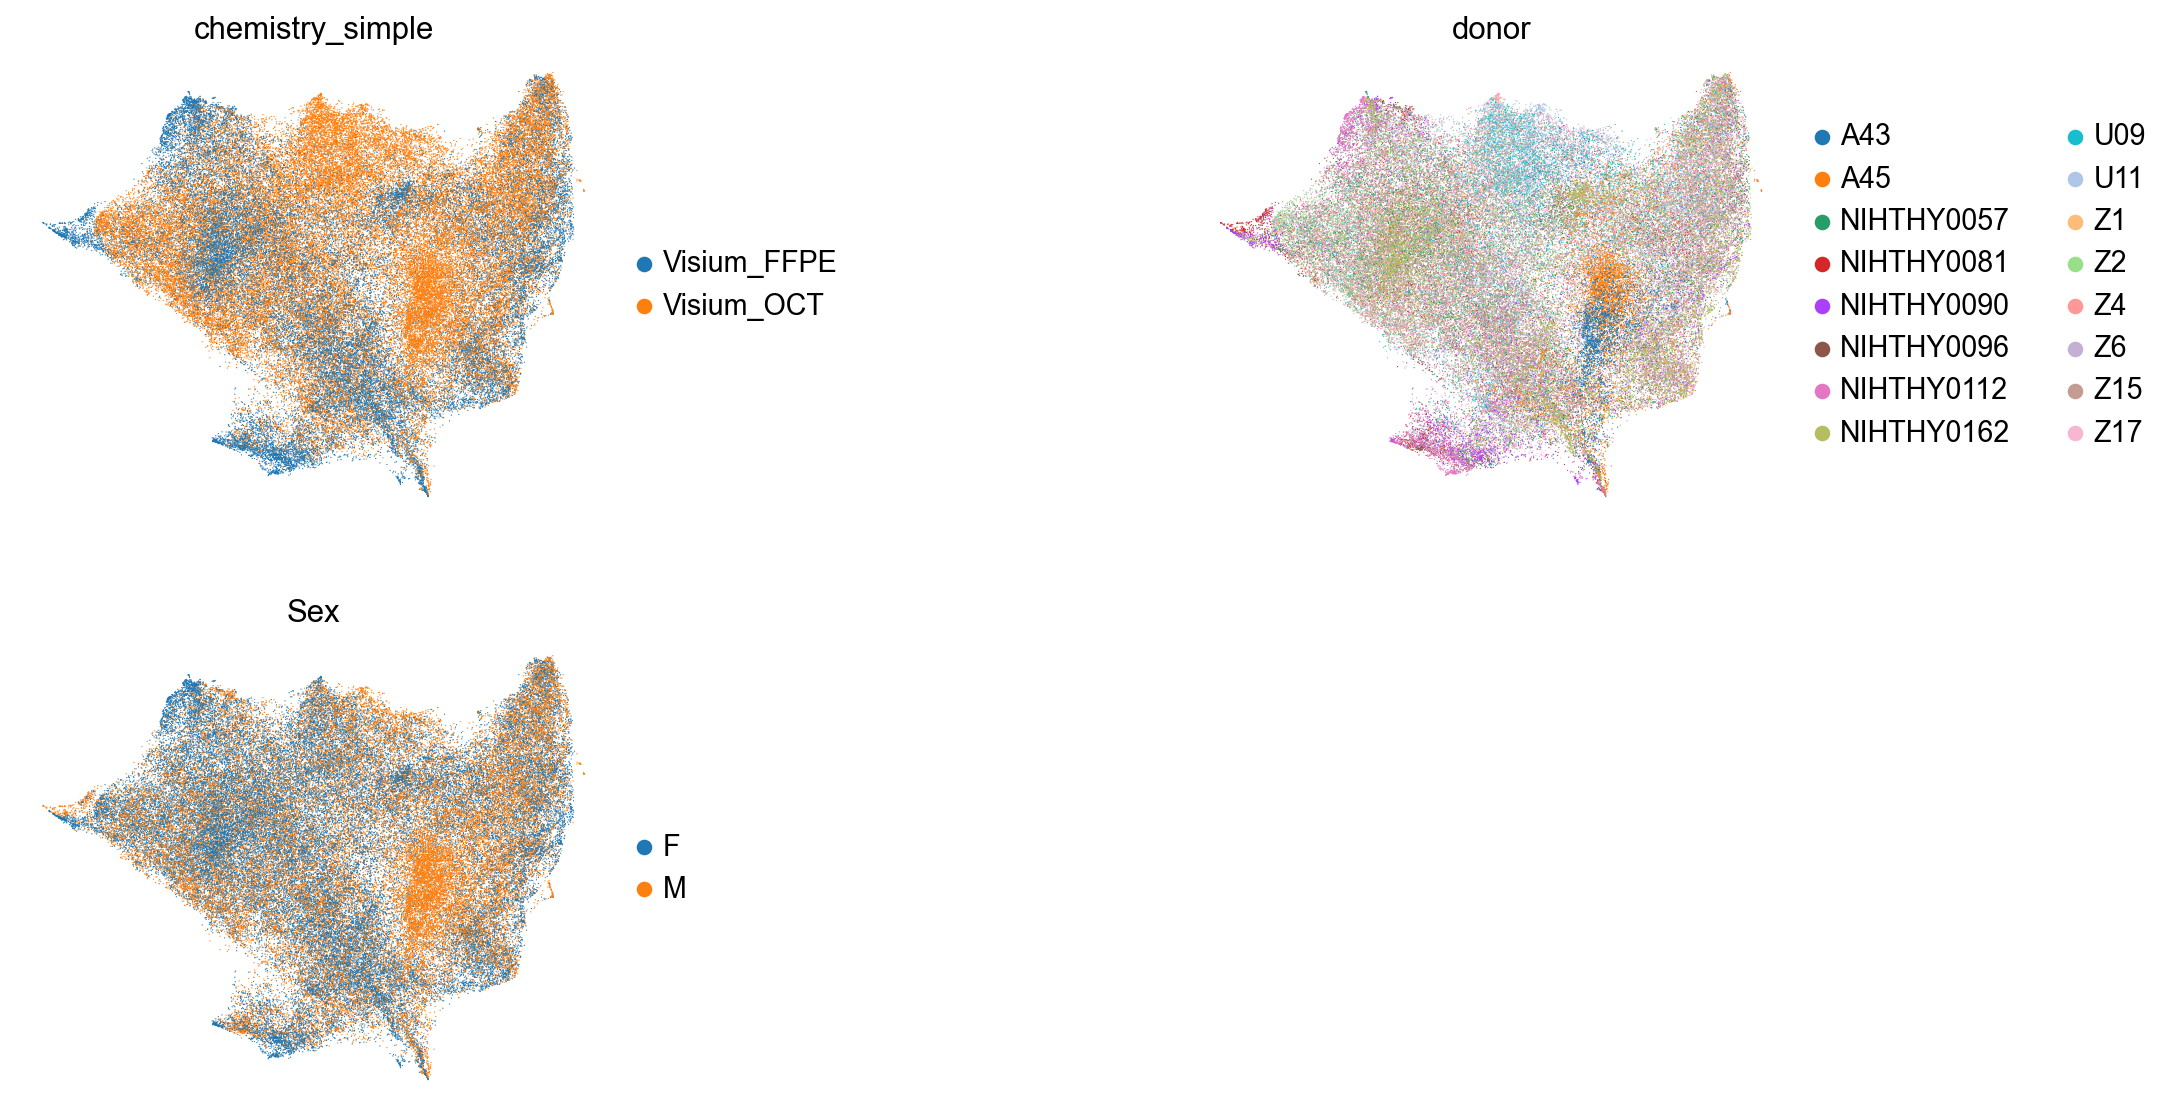

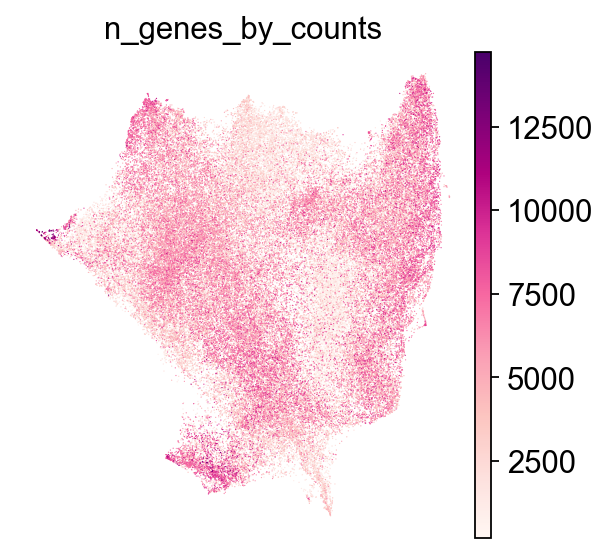

In [21]:
scvi_run = run_scvi(adata_vis_filt, 
                    # Excluded genes
                    include_genes=[], exclude_cc_genes=True, exclude_mt_genes=True, 
                    exclude_vdjgenes = True, remove_cite = False,
                    # Highly variable gene selection
                    batch_hv="chemistry_simple", hvg = 5000, span = 0.5,
                    # scVI 
                    batch_scvi="SampleID",
                    cat_cov_scvi=["chemistry_simple", "donor", "Sex"], 
                    cont_cov_scvi=['n_genes_by_counts'], 
                    max_epochs=400, batch_size=2000, # early_stopping = True, early_stopping_patience = 10, early_stopping_min_delta = 10,
                    check_val_every_n_epoch = 1,
                    plan_kwargs = {'lr': 0.0001}, n_layers = 2, n_latent = 30, dispersion = 'gene-batch',
                    # Leiden clustering
                    leiden_clustering = None, col_cell_type = 'chemistry_simple',
                   covs = {})

In [22]:
adata_scvi = scvi_run['data'].copy()

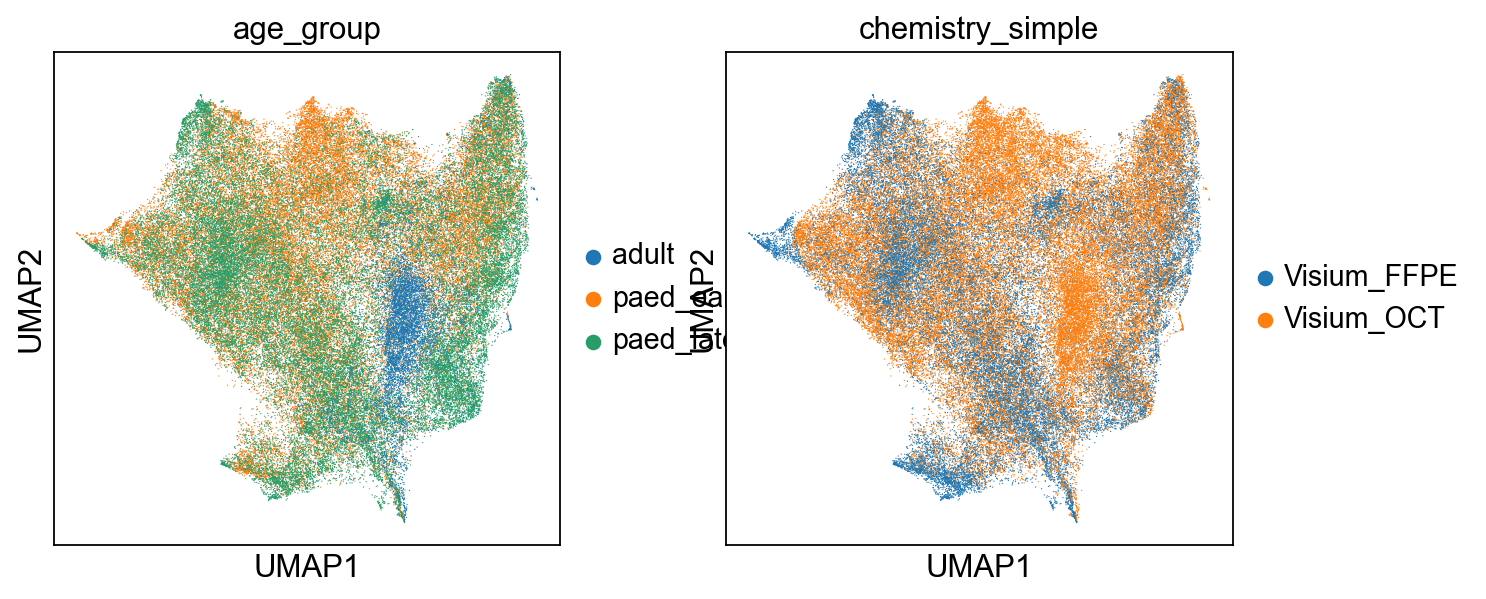

In [23]:
sc.pl.umap(adata_scvi, color = ['age_group', 'chemistry_simple'])

In [24]:
sc.pp.normalize_total(adata_scvi, target_sum=1e4)
sc.pp.log1p(adata_scvi)

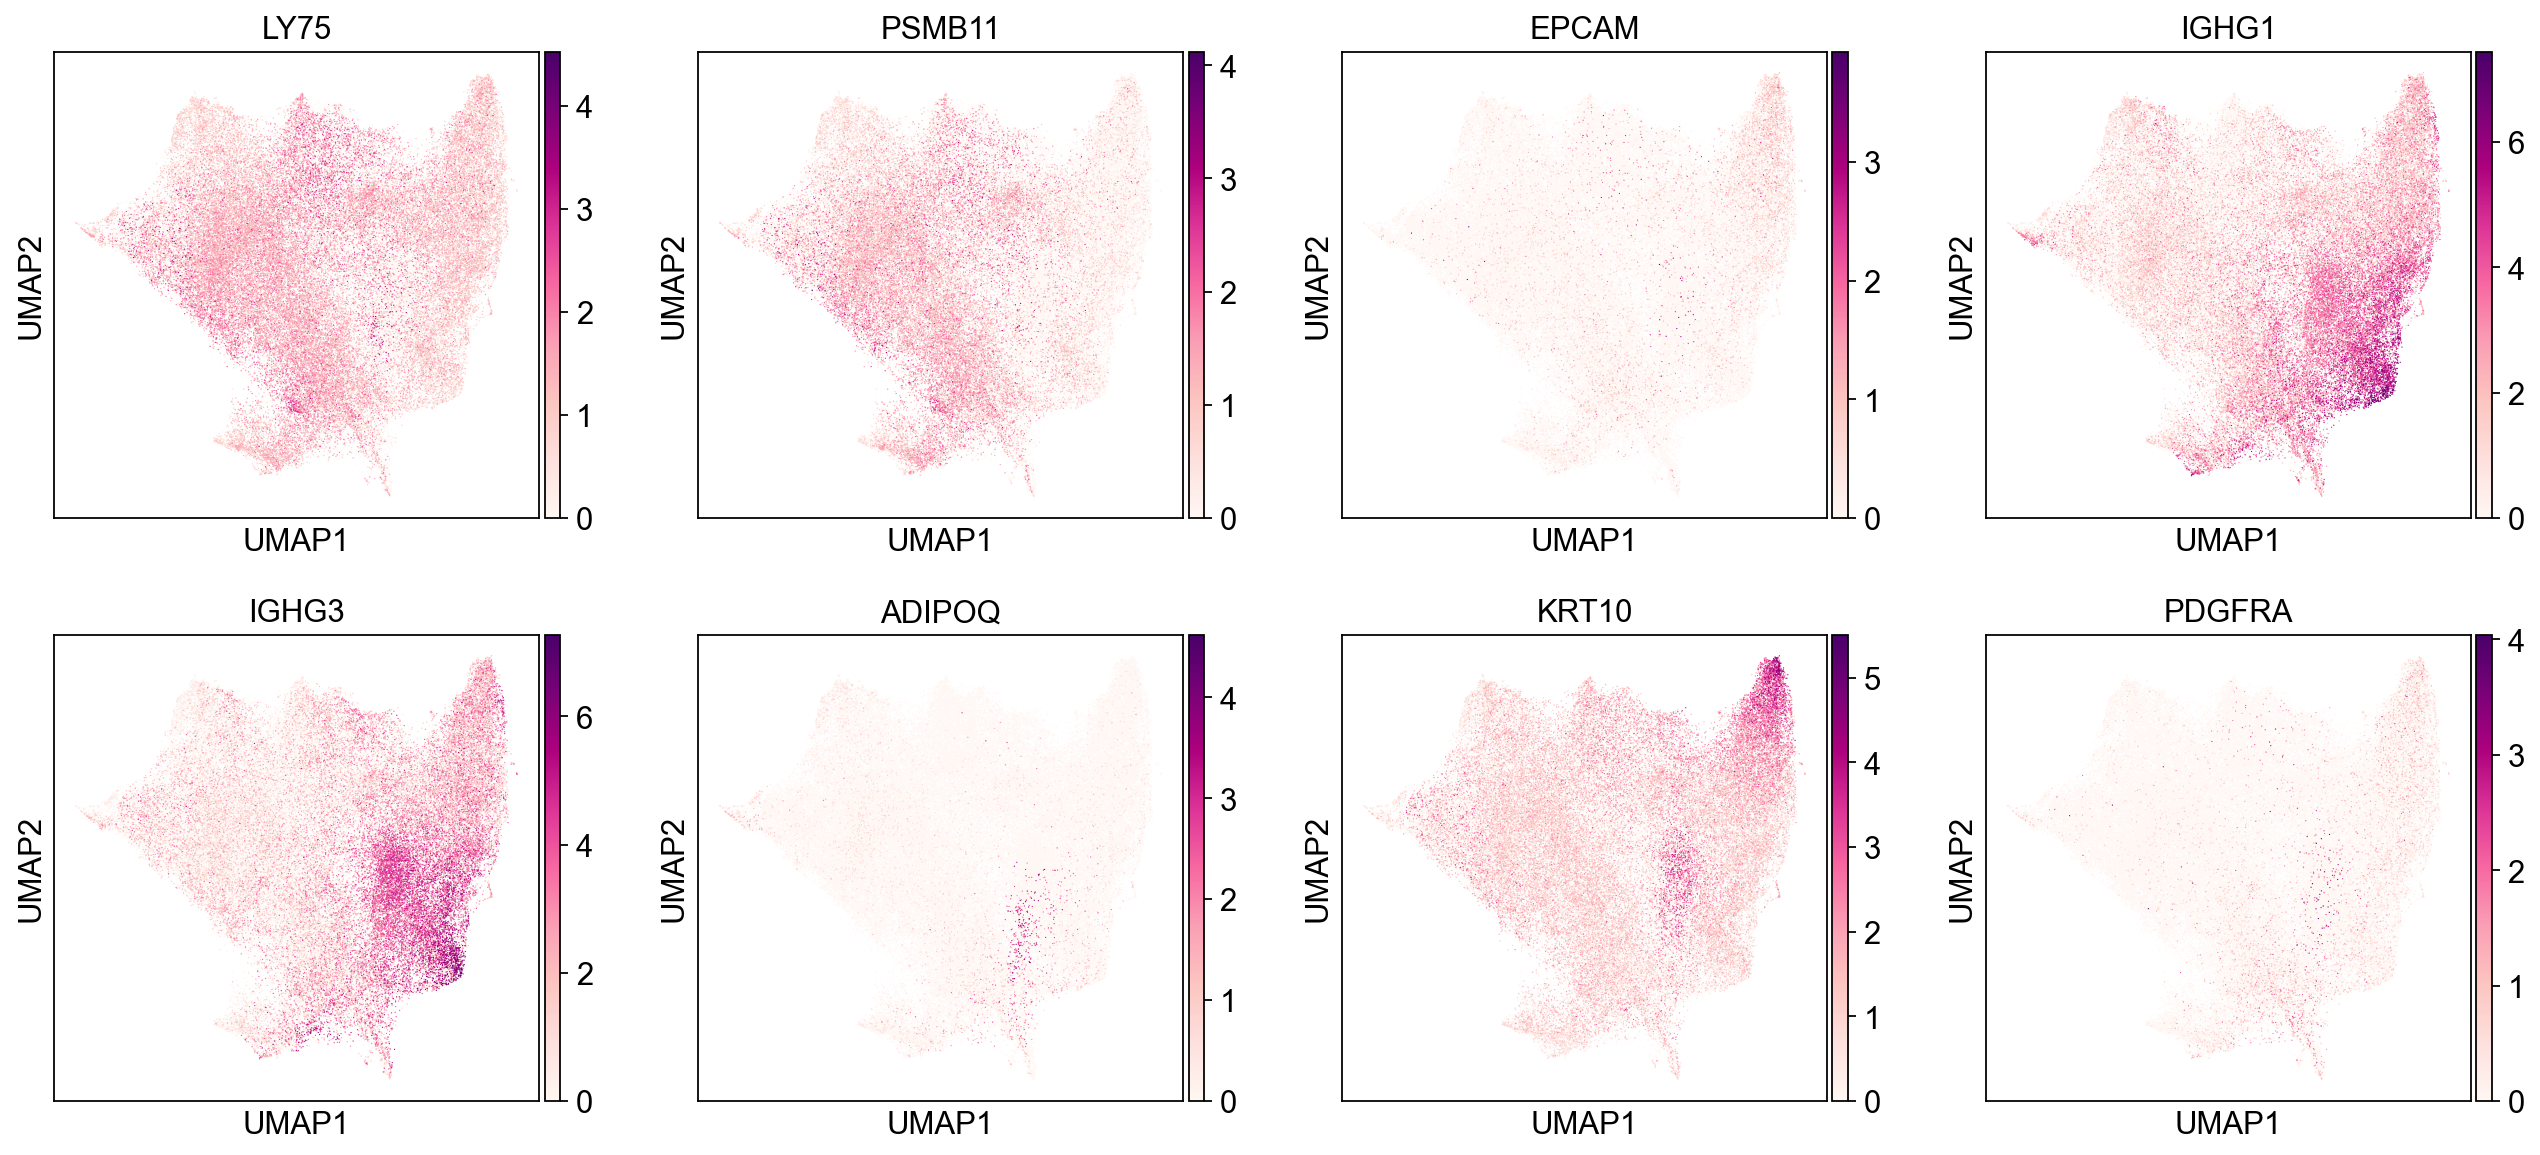

In [25]:
sc.pl.umap(adata_scvi, color = ['LY75', 'PSMB11', 'EPCAM', 'IGHG1', 'IGHG3', 'ADIPOQ', 'KRT10', 'PDGFRA'])

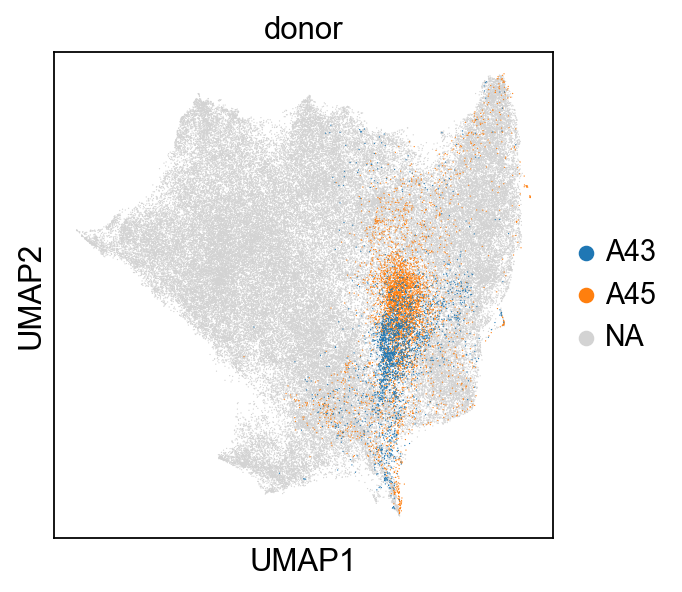

In [26]:
sc.pl.umap(adata_scvi, color = ['donor'], groups = ['A43', 'A45', 'A53', 'A56'])